<a href="https://colab.research.google.com/github/SnehAl2o7/EmployeeSalaryPredictorModel/blob/main/EmplyeeSalaryPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pandas numpy matplotlib seaborn
!pip install scikit-learn
!pip install xgboost lightgbm
!pip install plotly
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f0769ac59eea0cfdea4c8649bff42fc7eb014f24c9bae4fe9d526a3032ee4465
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Data loaded successfully from 'Employee_Perfoemance_dataset.csv'
Dataset Shape: (1000, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1000 non-null   int64  
 1   Name               1000 non-null   object 
 2   Age                1000 non-null   int64  
 3   Gender             1000 non-null   object 
 4   Department         1000 non-null   object 
 5   Salary             1000 non-null   int64  
 6   Joining Date       1000 non-null   object 
 7   Performance Score  502 non-null    float64
 8   Experience         1000 non-null   int64  
 9   Status             1000 non-null   object 
 10  Location           1000 non-null   object 
 11  Session            1000 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 93.9+ KB
None

Missing Values:
ID                     0
Name  

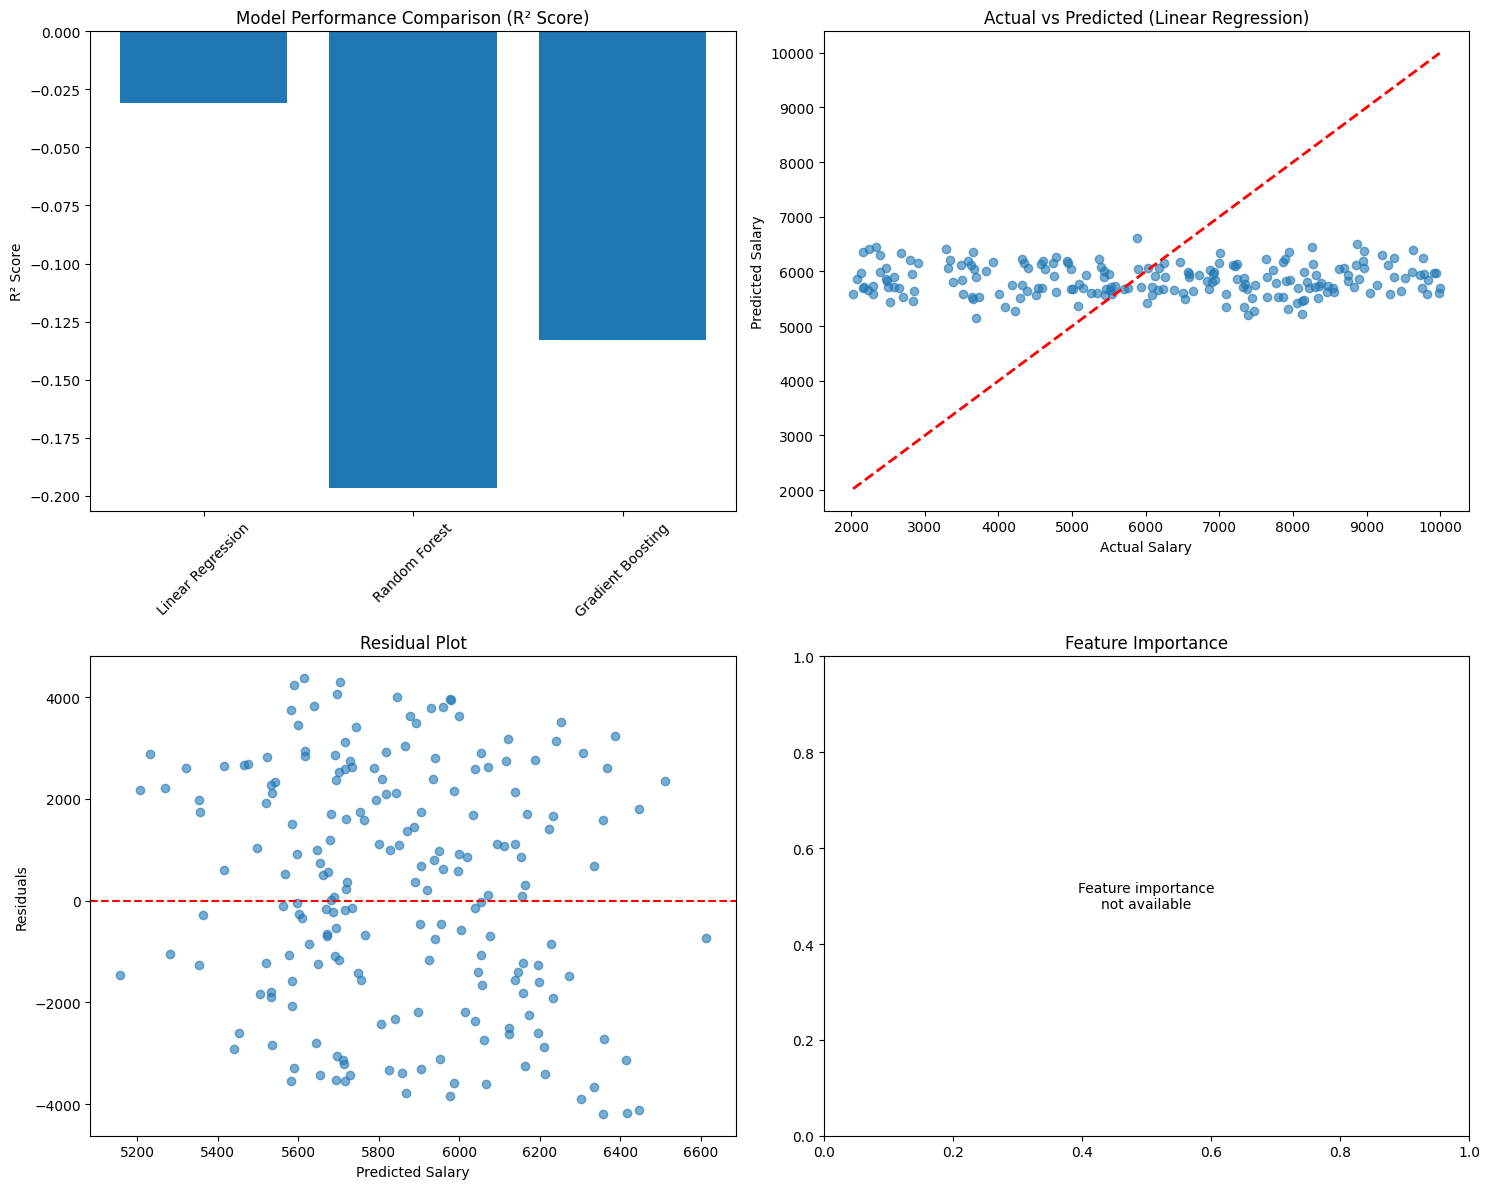


SALARY PREDICTION MODEL INSIGHTS

Dataset Overview:
- Total employees: 1000
- Average salary: $5,917.37
- Salary range: $2,015.00 - $9,993.00

Salary by Department:
- HR: $5,982.40 (n=323.0)
- IT: $5,968.37 (n=339.0)
- Sales: $5,804.09 (n=338.0)

Experience-Salary Correlation: 0.004
Performance-Salary Correlation: 0.001

Best Model Performance (Linear Regression):
- R² Score: -0.0307
- RMSE: $2,336.21
- MAE: $2,016.96

EXAMPLE SALARY PREDICTION

Predicted salary for new employee: $5,557.43
Employee profile: {'Age': 30, 'Gender': 'Female', 'Department': 'IT', 'Experience': 5, 'Performance Score': 4.2, 'Location': 'California', 'Status': 'Active'}


In [12]:
class EmployeeSalaryPredictor:
    def __init__(self):
        self.models = {}
        self.best_model = None
        self.preprocessor = None
        self.feature_importance = None

    def load_and_explore_data(self, df):
        """Load and explore the dataset"""
        print("Dataset Shape:", df.shape)
        print("\nDataset Info:")
        print(df.info())
        print("\nMissing Values:")
        print(df.isnull().sum())
        print("\nBasic Statistics:")
        print(df.describe())

        return df

    def feature_engineering(self, df):
        """Create additional features for better prediction"""
        df_processed = df.copy()

        df_processed.drop(columns=['Name', 'Session'], errors='ignore', inplace=True)


        # Convert Joining Date to datetime if it exists
        if 'Joining Date' in df_processed.columns:
            df_processed['Joining Date'] = pd.to_datetime(df_processed['Joining Date'], errors='coerce')

        # Create experience categories
        if 'Experience' in df_processed.columns:
            df_processed['Experience_Category'] = pd.cut(df_processed['Experience'],
                                                       bins=[0, 2, 5, 10, float('inf')],
                                                       labels=['Junior', 'Mid', 'Senior', 'Expert'],
                                                       right=False,  # Added right=False for consistency with typical bins
                                                       duplicates='drop') # Added duplicates='drop' to handle non-unique bin edges


        # Create age groups
        if 'Age' in df_processed.columns:
            df_processed['Age_Group'] = pd.cut(df_processed['Age'],
                                             bins=[0, 25, 35, 45, float('inf')],
                                             labels=['Young', 'Mid_Age', 'Mature', 'Senior'],
                                             right=False, # Added right=False
                                             duplicates='drop') # Added duplicates='drop'


        # Performance score categories
        if 'Performance Score' in df_processed.columns:
            df_processed['Performance_Category'] = pd.cut(df_processed['Performance Score'],
                                                        bins=[0, 3, 4, 5.1], # Adjusted upper bound slightly
                                                        labels=['Low', 'Medium', 'High'],
                                                        right=False, # Added right=False
                                                        duplicates='drop') # Added duplicates='drop'


        return df_processed

    def prepare_features(self, df, target_column='Salary'):
        """Prepare features for model training"""
        # Select relevant features
        feature_columns = ['Age', 'Gender', 'Department', 'Performance Score', 'Experience']

        # Add engineered features if they exist
        if 'Years_Since_Joining' in df.columns:
            feature_columns.append('Years_Since_Joining')
        if 'Experience_Category' in df.columns:
            feature_columns.append('Experience_Category')
        if 'Age_Group' in df.columns:
            feature_columns.append('Age_Group')
        if 'Performance_Category' in df.columns:
            feature_columns.append('Performance_Category')
        if 'Location' in df.columns:
            feature_columns.append('Location')
        if 'Status' in df.columns:
            feature_columns.append('Status')

        # Filter existing columns
        available_columns = [col for col in feature_columns if col in df.columns]

        X = df[available_columns]
        y = df[target_column]

        # Identify categorical and numerical columns
        categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

        print(f"Categorical features: {categorical_features}")
        print(f"Numerical features: {numerical_features}")

        return X, y, categorical_features, numerical_features

    def create_preprocessor(self, categorical_features, numerical_features):
        """Create preprocessing pipeline"""
        # Create preprocessing steps
        categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values
            ('scaler', StandardScaler())
        ])

        # Create preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        return preprocessor

    def train_models(self, X, y, categorical_features, numerical_features):
        """Train multiple models and find the best one"""
        # Create preprocessor
        self.preprocessor = self.create_preprocessor(categorical_features, numerical_features)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Define models to train
        models_to_train = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }

        best_score = -np.inf

        for name, model in models_to_train.items():
            # Create pipeline
            pipeline = Pipeline([
                ('preprocessor', self.preprocessor),
                ('regressor', model)
            ])

            # Train the model
            pipeline.fit(X_train, y_train)

            # Make predictions
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Cross-validation score
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
            cv_mean = cv_scores.mean()

            # Store model and results
            self.models[name] = {
                'pipeline': pipeline,
                'mse': mse,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'cv_score': cv_mean,
                'predictions': y_pred,
                'actual': y_test
            }

            print(f"\n{name} Results:")
            print(f"RMSE: ${rmse:,.2f}")
            print(f"MAE: ${mae:,.2f}")
            print(f"R² Score: {r2:.4f}")
            print(f"Cross-validation R² Score: {cv_mean:.4f} (+/- {cv_scores.std() * 2:.4f})")

            # Track best model
            if cv_mean > best_score:
                best_score = cv_mean
                self.best_model = pipeline
                self.best_model_name = name

        print(f"\nBest Model: {self.best_model_name} with CV R² Score: {best_score:.4f}")

        return X_test, y_test

    def hyperparameter_tuning(self, X, y, categorical_features, numerical_features):
        """Perform hyperparameter tuning for the best performing models"""
        print("\nPerforming Hyperparameter Tuning...")

        # Create preprocessor
        preprocessor = self.create_preprocessor(categorical_features, numerical_features)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random Forest tuning
        rf_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=42))
        ])

        rf_params = {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [10, 20, None],
            'regressor__min_samples_split': [2, 5],
            'regressor__min_samples_leaf': [1, 2]
        }

        rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
        rf_grid.fit(X_train, y_train)

        # Gradient Boosting tuning
        gb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', GradientBoostingRegressor(random_state=42))
        ])

        gb_params = {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.1, 0.05],
            'regressor__max_depth': [3, 5, 7],
            'regressor__min_samples_split': [2, 5]
        }

        gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
        gb_grid.fit(X_train, y_train)

        # Compare tuned models
        tuned_models = {
            'Tuned Random Forest': rf_grid.best_estimator_,
            'Tuned Gradient Boosting': gb_grid.best_estimator_
        }

        best_tuned_score = -np.inf
        best_tuned_model = None
        best_tuned_name = ""

        for name, model in tuned_models.items():
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            print(f"\n{name}:")
            print(f"R² Score: {r2:.4f}")
            print(f"RMSE: ${rmse:,.2f}")

            if r2 > best_tuned_score:
                best_tuned_score = r2
                best_tuned_model = model
                best_tuned_name = name

        # Update best model if tuned version is better
        if best_tuned_score > self.models[self.best_model_name]['r2']:
            self.best_model = best_tuned_model
            self.best_model_name = best_tuned_name
            print(f"\nUpdated Best Model: {self.best_model_name}")

        return best_tuned_model

    def get_feature_importance(self, X):
        """Extract feature importance from the best model"""
        if hasattr(self.best_model.named_steps['regressor'], 'feature_importances_'):
            # Get feature names after preprocessing
            feature_names = []

            # Get numerical feature names
            num_features_transformer = self.preprocessor.named_transformers_['num']
            # Access the scaler within the numerical transformer pipeline
            num_features_transformer_steps = dict(num_features_transformer.steps)
            # Assuming the scaler is the last step and has get_feature_names_out
            if 'scaler' in num_features_transformer_steps and hasattr(num_features_transformer_steps['scaler'], 'get_feature_names_out'):
                 feature_names.extend(num_features_transformer_steps['scaler'].get_feature_names_out())
            elif 'imputer' in num_features_transformer_steps and hasattr(num_features_transformer_steps['imputer'], 'get_feature_names_out'):
                 feature_names.extend(num_features_transformer_steps['imputer'].get_feature_names_out())
            else:
                # Fallback for older sklearn versions or other transformers
                numerical_features = X.select_dtypes(include=[np.number]).columns
                feature_names.extend(numerical_features)


            # Get categorical feature names
            cat_features_transformer = self.preprocessor.named_transformers_['cat']
            if hasattr(cat_features_transformer, 'get_feature_names_out'):
                feature_names.extend(cat_features_transformer.get_feature_names_out())
            else:
                 # Fallback for older sklearn versions or other transformers
                categorical_features_input = X.select_dtypes(include=['object', 'category']).columns
                # This fallback is not perfect as it won't give the one-hot encoded names
                # but it prevents an error if get_feature_names_out is missing.
                # A more robust solution might require inspecting the one-hot encoder's categories.
                print("Warning: Could not get one-hot encoded feature names directly. Feature importance names might be inaccurate for categorical features.")
                feature_names.extend(categorical_features_input)


            importances = self.best_model.named_steps['regressor'].feature_importances_

            # Ensure the number of feature names matches the number of importances
            if len(feature_names) != len(importances):
                 print(f"Warning: Mismatch between number of feature names ({len(feature_names)}) and importances ({len(importances)}). Feature importance display may be incorrect.")
                 # Truncate feature names or importances to match the smaller length
                 min_len = min(len(feature_names), len(importances))
                 feature_names = feature_names[:min_len]
                 importances = importances[:min_len]


            # Create feature importance dataframe
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            self.feature_importance = importance_df
            return importance_df
        else:
            print("Feature importance not available for this model type.")
            return None

    def plot_results(self):
        """Plot model results and feature importance"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Model Comparison
        model_names = list(self.models.keys())
        r2_scores = [self.models[name]['r2'] for name in model_names]

        axes[0,0].bar(model_names, r2_scores)
        axes[0,0].set_title('Model Performance Comparison (R² Score)')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)

        # Plot 2: Actual vs Predicted
        best_model_data = self.models[self.best_model_name]
        axes[0,1].scatter(best_model_data['actual'], best_model_data['predictions'], alpha=0.6)
        axes[0,1].plot([best_model_data['actual'].min(), best_model_data['actual'].max()],
                      [best_model_data['actual'].min(), best_model_data['actual'].max()], 'r--', lw=2)
        axes[0,1].set_xlabel('Actual Salary')
        axes[0,1].set_ylabel('Predicted Salary')
        axes[0,1].set_title(f'Actual vs Predicted ({self.best_model_name})')

        # Plot 3: Residuals
        residuals = best_model_data['actual'] - best_model_data['predictions']
        axes[1,0].scatter(best_model_data['predictions'], residuals, alpha=0.6)
        axes[1,0].axhline(y=0, color='r', linestyle='--')
        axes[1,0].set_xlabel('Predicted Salary')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].set_title('Residual Plot')

        # Plot 4: Feature Importance
        if self.feature_importance is not None:
            top_features = self.feature_importance.head(10)
            axes[1,1].barh(top_features['feature'], top_features['importance'])
            axes[1,1].set_xlabel('Feature Importance')
            axes[1,1].set_title('Top 10 Feature Importance')
        else:
            axes[1,1].text(0.5, 0.5, 'Feature importance\nnot available',
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Feature Importance')

        plt.tight_layout()
        plt.show()

    def predict_salary(self, employee_data):
        """Predict salary for new employee data"""
        if self.best_model is None:
            raise ValueError("Model not trained yet. Please train the model first.")

        # Convert to DataFrame if needed
        if isinstance(employee_data, dict):
            employee_data_df = pd.DataFrame([employee_data])
        else:
            employee_data_df = employee_data.copy()

        # Apply the same feature engineering as used during training
        employee_data_processed = self.feature_engineering(employee_data_df)

        # Make prediction
        # The preprocessor in the best_model pipeline will handle the transformation
        prediction = self.best_model.predict(employee_data_processed)



        return prediction

    def generate_insights(self, df):
        """Generate insights from the data and model"""
        print("\n" + "="*50)
        print("SALARY PREDICTION MODEL INSIGHTS")
        print("="*50)

        # Basic statistics
        print(f"\nDataset Overview:")
        print(f"- Total employees: {len(df)}")
        print(f"- Average salary: ${df['Salary'].mean():,.2f}")
        print(f"- Salary range: ${df['Salary'].min():,.2f} - ${df['Salary'].max():,.2f}")

        # Department insights
        if 'Department' in df.columns:
            dept_stats = df.groupby('Department')['Salary'].agg(['mean', 'count']).round(2)
            print(f"\nSalary by Department:")
            for dept, stats in dept_stats.iterrows():
                print(f"- {dept}: ${stats['mean']:,.2f} (n={stats['count']})")

        # Experience insights
        if 'Experience' in df.columns:
            exp_corr = df['Experience'].corr(df['Salary'])
            print(f"\nExperience-Salary Correlation: {exp_corr:.3f}")

        # Performance insights
        if 'Performance Score' in df.columns:
            perf_corr = df['Performance Score'].corr(df['Salary'])
            print(f"Performance-Salary Correlation: {perf_corr:.3f}")

        # Model performance
        print(f"\nBest Model Performance ({self.best_model_name}):")
        best_metrics = self.models[self.best_model_name]
        print(f"- R² Score: {best_metrics['r2']:.4f}")
        print(f"- RMSE: ${best_metrics['rmse']:,.2f}")
        print(f"- MAE: ${best_metrics['mae']:,.2f}")

        # Feature importance insights
        if self.feature_importance is not None:
            print(f"\nTop 3 Most Important Features:")
            for i, row in self.feature_importance.head(3).iterrows():
                print(f"{i+1}. {row['feature']}: {row['importance']:.3f}")

# Example usage
def main():
    """Main function to demonstrate the salary prediction model"""

    # Initialize the predictor
    predictor = EmployeeSalaryPredictor()

    # Load data from CSV (replace with your actual data path if needed)
    try:
        df = pd.read_csv('/content/Employe_Performance_dataset.csv')
        print("Data loaded successfully from 'Employee_Perfoemance_dataset.csv'")
    except FileNotFoundError:
        print("Error: 'Employee_Perfoemance_dataset.csv' not found. Please upload the file.")
        return None, None # Exit if file not found


    # Load and explore data
    df = predictor.load_and_explore_data(df)

    # Feature engineering
    df = predictor.feature_engineering(df)

    # Prepare features
    X, y, categorical_features, numerical_features = predictor.prepare_features(df)

    # Train models
    X_test, y_test = predictor.train_models(X, y, categorical_features, numerical_features)

    # Hyperparameter tuning
    predictor.hyperparameter_tuning(X, y, categorical_features, numerical_features)

    # Get feature importance
    predictor.get_feature_importance(X)

    # Plot results
    predictor.plot_results()

    # Generate insights
    predictor.generate_insights(df)

    # Example prediction
    print("\n" + "="*50)
    print("EXAMPLE SALARY PREDICTION")
    print("="*50)

    new_employee = {
        'Age': 30,
        'Gender': 'Female',
        'Department': 'IT',
        'Experience': 5,
        'Performance Score': 4.2,
        'Location': 'California',
        'Status': 'Active'
    }

    predicted_salary = predictor.predict_salary(new_employee)
    print(f"\nPredicted salary for new employee: ${predicted_salary[0]:,.2f}")
    print(f"Employee profile: {new_employee}")

    return predictor, df

if __name__ == "__main__":
    predictor, df = main()